In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils_data import read_numbered_dataset_df
from datasets import load_from_disk
from transformer_lens import HookedTransformer
import os
import requests, json, os, glob, torch
from utils_sae import get_gemma_2_9b_sae_ids_largest_l0s, load_gemma_2_9b_sae, get_xy_OOD_sae
from utils_data import get_dataset_sizes, get_xy_traintest, get_OOD_datasets, get_xy_OOD, get_xyvals
from nnsight import LanguageModel
from huggingface_hub import login
PER_DATASET = 300 #num of test examples
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 6,          # Title size for axes
    'axes.labelsize': 6,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 6,        # Overall figure title size
})
model_name = 'gemma-2-9b'
device = 'cuda:1'

# We do all OOD plots here
This file is reversed such that the plotting functions on the experiment data are at the beginning,
while generating dataset activations and such are towards the end. To run probes on generated activations, please see the relevant section of run_baselines.py

# Plot OOD Pruned
Fig. 20

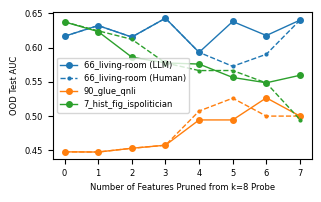

In [26]:
def get_results(dataset, ret='human'):
    return pd.read_csv(f'results/sae_probes_gemma-2-9b/OOD/OOD_latents/{dataset}/{dataset}_pruned.csv')[f'ood_auc_{ret}']

def plot_pruned():
    datasets = ['66_living-room', '90_glue_qnli', '7_hist_fig_ispolitician']
    plt.figure(figsize=(3.25, 2))
    
    for i, dataset in enumerate(datasets):
        res_llm = list(get_results(dataset, ret='llm'))
        k  = list(range(len(res_llm)))
        if i == 0:
            plt.plot(k, res_llm[::-1], 'o-', label=dataset + ' (LLM)', linewidth=1, markersize=4)
            res_human = list(get_results(dataset, ret='human'))
            plt.plot(k, res_human[::-1], 'o--', label=dataset + ' (Human)', linewidth=1, markersize=2, color=plt.gca().lines[-1].get_color())
        else:
            plt.plot(k, res_llm[::-1], 'o-', label=dataset, linewidth=1, markersize=4)
            res_human = list(get_results(dataset, ret='human'))
            plt.plot(k, res_human[::-1], 'o--', linewidth=1, markersize=2, color=plt.gca().lines[-1].get_color())
    
    plt.xlabel('Number of Features Pruned from k=8 Probe')
    plt.ylabel('OOD Test AUC')
    plt.legend()
    #plt.gca().invert_xaxis()  # Reverse x-axis direction
    savename = 'figures/OOD/OOD_pruned'
    plt.tight_layout()
    os.makedirs('figures/OOD', exist_ok=True)
    plt.savefig(f'{savename}.pdf', dpi=300)
    plt.savefig(f'{savename}.png', dpi=300)

plot_pruned()

# Plot OOD

In [7]:
descriptions = ['Fictional Characters', 'Random Letter Inserted', 'Reversed Name Order', 'Translated to French', 'Translated to Spanish','Translated to German', 'GLUE-X OOD', 'GLUE-X OOD']
def get_data():
    df = pd.read_csv('results/baseline_probes_gemma-2-9b/ood/all_results.csv')
    # Extract numbers from dataset names and sort
    df['num'] = df['dataset'].str.extract('(\d+)').astype(int)
    df = df.sort_values('num')
    df['description'] = descriptions
    df = df.drop('num', axis=1)
    return df


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2676639/2758099589.py:5: SyntaxWarning: invalid escape sequence '\d'
  df['num'] = df['dataset'].str.extract('(\d+)').astype(int)


# Plot the OOD performance of SAE probes and baseliens
Fig. 7

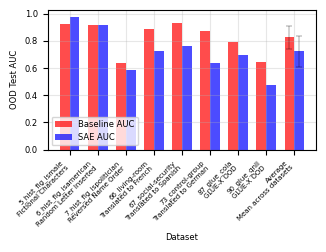

In [8]:
def plot_data():
    df = get_data()
    
    # Calculate averages and standard errors
    avg_baseline = df['test_auc_baseline'].mean()
    avg_sae = df['test_auc_sae'].mean()
    se_baseline = df['test_auc_baseline'].std() / np.sqrt(len(df))
    se_sae = df['test_auc_sae'].std() / np.sqrt(len(df))
    
    # Calculate 95% confidence intervals
    ci_baseline = 1.96 * se_baseline
    ci_sae = 1.96 * se_sae
    
    avg_row = pd.DataFrame({
        'dataset': ['Average'],
        'test_auc_baseline': [avg_baseline],
        'test_auc_sae': [avg_sae],
        'description': ['Mean across datasets']
    })
    df = pd.concat([df, avg_row], ignore_index=True)
    
    plt.figure(figsize=(3.25, 2.5))
    
    # Set up bar positions
    x = np.arange(len(df))
    width = 0.35  # Width of bars
    
    # Create bars
    baseline_bars = plt.bar(x - width/2, df['test_auc_baseline'], width, label='Baseline AUC', color='red', alpha=0.7)
    sae_bars = plt.bar(x + width/2, df['test_auc_sae'], width, label='SAE AUC', color='blue', alpha=0.7)

    
    # Add error bars for average (last bars)
    plt.errorbar(x[-1] - width/2, avg_baseline, yerr=ci_baseline, color='black', capsize=2, capthick=0.25, linewidth=0.25)
    plt.errorbar(x[-1] + width/2, avg_sae, yerr=ci_sae, color='black', capsize=2, capthick=0.25, linewidth=0.25)
    
    # Customize plot
    plt.xlabel('Dataset')
    plt.ylabel('OOD Test AUC')
    #plt.title('Baseline vs SAE Performance Across Datasets')
    plt.xticks(x, [f"{row['dataset']}\n{row['description']}" for _, row in df.iterrows()], rotation=45, ha='right', fontsize = 5)
    plt.legend(loc = 'lower left')
    
    # Adjust layout to prevent label cutoff
    plt.grid(alpha = 0.3)
    plt.tight_layout()
    savename = f'figures/OOD/ood_task_comp'
    plt.savefig(f'{savename}.pdf', dpi = 300)
    plt.savefig(f'{savename}.png', dpi = 300)
    
    plt.show()

plot_data()

# Generate SAE activations

In [ ]:
sae_id = get_gemma_2_9b_sae_ids_largest_l0s(layer = 20)[-1]
sae_id = 'layer_20/width_131k/average_l0_114'
sae = load_gemma_2_9b_sae(sae_id).to(device)
sae

In [ ]:
def save_activations(path, activation):
    sparse_tensor = activation.to_sparse()
    torch.save(sparse_tensor, path)
    
def save_with_sae(sae, layer = 20):
    datasets = get_OOD_datasets()
    with torch.no_grad():
        for dataset in tqdm(datasets):
            for ood in ['_OOD', '']:
                os.makedirs(f"data/sae_activations_{model_name}{ood}", exist_ok=True)
                path = f"data/sae_activations_{model_name}{ood}/{dataset}{ood}.pt"
                if ood == '_OOD':
                    X, y = get_xy_OOD(dataset, model_name = model_name,layer = layer)
                else:
                    X,y = get_xyvals(dataset, layer = layer, model_name = model_name, MAX_AMT = 1500)
                batch_size = 128
                X_sae = []
                for i in range(0, len(X), batch_size):
                    batch = X[i:i+batch_size].to(device)
                    X_sae.append(sae.encode(batch))
                X_sae = torch.cat(X_sae).cpu()
                print(X_sae.shape)
                save_activations(path, X_sae)

save_with_sae(sae)

# Get OOD activations

In [ ]:
if model_name == "gemma-2-9b":
    model = HookedTransformer.from_pretrained("google/gemma-2-9b", device=device)
elif model_name == "llama-3.1-8b":
    model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B", device=device)
else:
    raise ValueError(f"Model {model_name} not supported")
os.makedirs(f"data/model_activations_{model_name}_OOD", exist_ok=True)

# Get Dataset activations

In [3]:
tokenizer = model.tokenizer
tokenizer.truncation_side='left'
tokenizer.padding_side='right'
if model_name == "gemma-2-9b":
    hook_names = [f"blocks.{layer}.hook_resid_post" for layer in [20]]
elif model_name == "llama-3.1-8b":
    hook_names = ["hook_embed"] + [f"blocks.{layer}.hook_resid_post" for layer in [8, 16, 24, 31]]
else:
    raise ValueError(f"Model {model_name} not supported")

In [ ]:
dataset_names = glob.glob("data/OOD data/*.csv")
max_seq_len = 1024
with torch.no_grad():
    for dataset_name in tqdm(dataset_names):
        dataset = pd.read_csv(dataset_name)
        dataset_short_name = dataset_name.split("/")[-1].split(".")[0]
        file_names = [f"data/model_activations_{model_name}_OOD/{dataset_short_name}_{hook_name}.pt" for hook_name in hook_names]
        lengths = None
        if all(os.path.exists(file_name) for file_name in file_names):
            lengths = [torch.load(file_name, weights_only=True).shape[0] for file_name in file_names]

        text = dataset["prompt"].tolist()
        
        text_lengths = []
        for t in text:
            text_lengths.append(len(tokenizer(t)['input_ids']))

        if lengths is not None and all(length == len(text_lengths) for length in lengths):
            print(f"Skipping {dataset_short_name} because correct length activations already exist")
            continue

        if lengths is not None:
            print(f"Generating activations for {dataset_short_name} (bad existing activations)")
            print(lengths, len(text_lengths))
        else:
            print(f"Generating activations for {dataset_short_name} (no existing activations)")


        batch_size = 1
        all_activations = {hook_name: [] for hook_name in hook_names}
        print('hey')
        bar = tqdm(range(0, len(text), batch_size))
        for i in bar:
            batch_text = text[i:i+batch_size]
            batch_lengths = text_lengths[i:i+batch_size]
            batch = tokenizer(batch_text, padding=True, truncation=True, max_length=max_seq_len, return_tensors="pt")
            batch = batch.to(device)
            logits, cache = model.run_with_cache(batch["input_ids"], names_filter=hook_names)
            for j, length in enumerate(batch_lengths):
                for hook_name in hook_names:
                    activation_pos = min(length - 1, max_seq_len - 1)
                    all_activations[hook_name].append(cache[hook_name][:, activation_pos].cpu())
            del logits, cache
            bar.set_description(f"{len(all_activations[hook_name])}")

        print(i, len(all_activations[hook_name]), len(torch.cat(all_activations[hook_name])))

        for hook_name, file_name in zip(hook_names, file_names):
            all_activations[hook_name] = torch.cat(all_activations[hook_name])
            torch.save(all_activations[hook_name], file_name)